# Hess-MC² Profiling

Break down wall-clock time by operation for a realistically complex SSM.
Runs each stage of `fit_hessmc2` manually and times it, so we can see
where the time actually goes.

**Model:** 4 latent, 6 Poisson manifest, free loadings, free cint, Student-t process noise.  
**Settings:** N=32 SMC particles, K=10 iterations, N_PF=100, T=100.

In [ ]:
from __future__ import annotations

import time
from collections import OrderedDict

import jax
import jax.numpy as jnp
import jax.random as random
import jax.scipy.linalg as jla
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
from jax.flatten_util import ravel_pytree
from numpyro import handlers

from causal_ssm_agent.orchestrator.schemas_model import DistributionFamily
from causal_ssm_agent.models.ssm import (
    SSMModel,
    SSMPriors,
    SSMSpec,
    discretize_system,
)
from causal_ssm_agent.models.ssm.hessmc2 import (
    _assemble_deterministics,
    _build_eval_fns,
    _compute_weight,
    _discover_sites,
    _propose_fo,
    _propose_rw,
    _propose_so,
    _reverse_fo,
    _reverse_rw,
    _reverse_so,
)

print(f"JAX {jax.__version__}  backend={jax.default_backend()}  devices={jax.devices()}")

## 1. Build a complex model + synthetic data

In [ ]:
# --- Config ---
n_latent, n_manifest = 4, 6
T, dt = 100, 0.5
N = 32       # SMC particles
K = 10       # SMC iterations
N_PF = 100   # PF particles
PROPOSAL = "hessian"  # change to "rw" or "mala" to profile those
STEP_SIZE = 0.01
FB_STEP_SIZE = 0.005

# --- Ground truth ---
key = random.PRNGKey(42)
true_drift = jnp.array([
    [-0.8,  0.15,  0.0,  0.0],
    [ 0.2, -0.6,  0.1,  0.0],
    [ 0.0, -0.2, -0.5,  0.1],
    [ 0.0,  0.0,  0.3, -0.7],
])
true_diff_diag = jnp.array([0.3, 0.25, 0.2, 0.2])
true_cint = jnp.array([0.3, 0.0, -0.2, 0.1])
true_lambda = jnp.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0.6, 0.4, 0, 0],
    [0, 0, 0.3, 0.7],
], dtype=float)
log_baselines = jnp.log(jnp.array([5.0, 3.0, 4.0, 6.0, 4.0, 3.0]))

# --- Simulate ---
diff_cov = jnp.diag(true_diff_diag ** 2)
Ad, Qd, cd = discretize_system(true_drift, diff_cov, true_cint, dt)
Qd_chol = jla.cholesky(Qd + jnp.eye(n_latent) * 1e-8, lower=True)

key, ik = random.split(key)
x = 0.5 * random.normal(ik, (n_latent,))
states = [x]
for _ in range(T - 1):
    key, nk = random.split(key)
    x = Ad @ x + cd.flatten() + Qd_chol @ random.normal(nk, (n_latent,))
    states.append(x)
latent = jnp.stack(states)

rates = jnp.exp(jax.vmap(lambda s: true_lambda @ s + log_baselines)(latent))
key, ok = random.split(key)
obs = random.poisson(ok, rates).astype(float)
times = jnp.arange(T, dtype=float) * dt

# --- Model ---
spec = SSMSpec(
    n_latent=n_latent, n_manifest=n_manifest,
    drift="free", diffusion="diag", cint="free",
    lambda_mat="free", manifest_means="free", manifest_var="diag",
    t0_means="free", t0_var="diag",
    manifest_dist=DistributionFamily.POISSON,
    diffusion_dist=DistributionFamily.STUDENT_T,
)
priors = SSMPriors(
    drift_diag={"mu": -0.5, "sigma": 0.5},
    drift_offdiag={"mu": 0.0, "sigma": 0.3},
    diffusion_diag={"sigma": 0.5},
    cint={"mu": 0.0, "sigma": 0.5},
    lambda_free={"mu": 0.5, "sigma": 0.5},
    manifest_means={"mu": 0.0, "sigma": 2.0},
    manifest_var_diag={"sigma": 0.5},
)
model = SSMModel(spec, priors=priors, n_particles=N_PF, pf_seed=42)

print(f"Latent shape: {latent.shape}, Obs shape: {obs.shape}")
print(f"Config: n_latent={n_latent}, n_manifest={n_manifest}, T={T}, N={N}, K={K}, N_PF={N_PF}")

## 2. Profile each stage

In [3]:
timings = OrderedDict()

def tic():
    jax.block_until_ready(obs)  # sync device
    return time.perf_counter()

def toc(t0, label):
    # Block until all JAX computation finishes
    jax.effects_barrier()
    elapsed = time.perf_counter() - t0
    timings[label] = elapsed
    print(f"  {label:<40s} {elapsed:>8.3f}s")
    return elapsed

In [4]:
rng_key = random.PRNGKey(0)
subject_ids = None

# --- Stage 1: Discover sites ---
t0 = tic()
rng_key, trace_key = random.split(rng_key)
site_info = _discover_sites(model, obs, times, subject_ids, trace_key)
example_unc = {name: info["transform"].inv(info["value"]) for name, info in site_info.items()}
flat_example, unravel_fn = ravel_pytree(example_unc)
D = flat_example.shape[0]
toc(t0, "1. discover_sites + ravel")
print(f"     D = {D}")
print(f"     Sites: {list(site_info.keys())}")

  1. discover_sites + ravel                   2.986s
     D = 53
     Sites: ['drift_diag_pop', 'drift_offdiag_pop', 'diffusion_diag_pop', 'cint_pop', 'lambda_free', 'manifest_means', 'manifest_var_diag', 't0_means_pop', 't0_var_diag', 'proc_df']


In [5]:
# --- Stage 2: Build eval fns (no compute, just closures) ---
t0 = tic()
log_lik_fn, log_prior_unc_fn = _build_eval_fns(
    model, obs, times, subject_ids, site_info, unravel_fn
)

def log_post_fn(z):
    return log_lik_fn(z) + log_prior_unc_fn(z)

def _safe_log_post(z):
    ll = log_lik_fn(z)
    lp = log_prior_unc_fn(z)
    return jnp.where(jnp.isfinite(ll) & jnp.isfinite(lp), lp + ll, -1e30)

def _safe_val_and_grad(z):
    val, grad = jax.value_and_grad(log_post_fn)(z)
    safe_val = jnp.where(jnp.isfinite(val), val, -1e30)
    safe_grad = jnp.nan_to_num(grad, nan=0.0, posinf=0.0, neginf=0.0)
    return safe_val, safe_grad

def _safe_full_hessian(z):
    H = jax.hessian(log_post_fn)(z)
    return jnp.nan_to_num(H, nan=0.0, posinf=0.0, neginf=0.0)

batch_log_post = jax.jit(jax.vmap(_safe_log_post))
batch_log_prior = jax.jit(jax.vmap(log_prior_unc_fn))
batch_val_and_grad = jax.jit(jax.vmap(_safe_val_and_grad))
batch_hessian = jax.jit(jax.vmap(_safe_full_hessian))

toc(t0, "2. build_eval_fns + closures")

  2. build_eval_fns + closures                0.000s


0.0004104999825358391

In [6]:
# --- Stage 3: Init particles from prior (vectorized) ---
t0 = tic()
parts = []
for name in sorted(site_info.keys()):
    info = site_info[name]
    rng_key, sample_key = random.split(rng_key)
    prior_samples = info["distribution"].sample(sample_key, (N,))
    unc_samples = info["transform"].inv(prior_samples)
    parts.append(unc_samples.reshape(N, -1))
particles = jnp.concatenate(parts, axis=1)
toc(t0, "3. init particles (vectorized prior)")
print(f"     particles shape: {particles.shape}")

  3. init particles (vectorized prior)        1.330s
     particles shape: (32, 53)


In [7]:
# --- Stage 4a: JIT compile batch_log_post ---
t0 = tic()
log_posts = batch_log_post(particles)
log_posts.block_until_ready()
toc(t0, "4a. batch_log_post (incl JIT compile)")

  4a. batch_log_post (incl JIT compile)       1.431s


1.4314309579785913

In [8]:
# --- Stage 4b: batch_log_post cached ---
t0 = tic()
log_posts = batch_log_post(particles)
log_posts.block_until_ready()
toc(t0, "4b. batch_log_post (cached)")

  4b. batch_log_post (cached)                 0.273s


0.2733567920513451

In [9]:
# --- Stage 5a: JIT compile batch_val_and_grad ---
t0 = tic()
log_posts, grads = batch_val_and_grad(particles)
grads.block_until_ready()
toc(t0, "5a. batch_val_and_grad (incl JIT compile)")

  5a. batch_val_and_grad (incl JIT compile)    3.166s


3.16556950006634

In [10]:
# --- Stage 5b: batch_val_and_grad cached ---
t0 = tic()
log_posts, grads = batch_val_and_grad(particles)
grads.block_until_ready()
toc(t0, "5b. batch_val_and_grad (cached)")

  5b. batch_val_and_grad (cached)             0.742s


0.7417606249218807

In [11]:
# --- Stage 5c: JIT compile batch_hessian ---
t0 = tic()
hessians = batch_hessian(particles)
hessians.block_until_ready()
toc(t0, "5c. batch_hessian (incl JIT compile)")
print(f"     hessians shape: {hessians.shape}")

# --- Stage 5d: batch_hessian cached ---
t0 = tic()
hessians = batch_hessian(particles)
hessians.block_until_ready()
toc(t0, "5d. batch_hessian (cached)")

  5c. batch_hessian (incl JIT compile)        6.880s
     hessians shape: (32, 53, 53)


  5d. batch_hessian (cached)                  2.209s


2.2086848750477657

In [12]:
# --- Stage 6: batch_log_prior ---
t0 = tic()
init_log_priors = batch_log_prior(particles)
init_log_priors.block_until_ready()
toc(t0, "6a. batch_log_prior (incl JIT compile)")

t0 = tic()
init_log_priors = batch_log_prior(particles)
init_log_priors.block_until_ready()
toc(t0, "6b. batch_log_prior (cached)")

  6a. batch_log_prior (incl JIT compile)      0.082s
  6b. batch_log_prior (cached)                0.000s


9.054201655089855e-05

In [13]:
# --- Stage 7: One full SMC iteration (propose + eval + reverse + weight) ---
from blackjax.smc.resampling import systematic as _systematic_resample

if PROPOSAL == "rw":
    _prop, _rev = _propose_rw, _reverse_rw
elif PROPOSAL == "mala":
    _prop, _rev = _propose_fo, _reverse_fo
else:
    _prop, _rev = _propose_so, _reverse_so

propose_batch = jax.jit(jax.vmap(_prop, in_axes=(0, 0, 0, 0, None, None)))
reverse_batch = jax.jit(jax.vmap(_rev, in_axes=(0, 0, 0, None, None)))
weight_batch = jax.jit(jax.vmap(_compute_weight, in_axes=(0, 0, 0, 0, 0, 0, 0, 0, 0, None)))

logw = log_posts - init_log_priors

# Warmup JIT for propose/reverse/weight
z_all = random.normal(random.PRNGKey(99), (N, D))
_ = propose_batch(particles, grads, hessians, z_all, STEP_SIZE, FB_STEP_SIZE)

print("\nOne full SMC iteration breakdown:")

# Resample
t0 = tic()
lse = jax.nn.logsumexp(logw)
wn = jnp.exp(logw - lse)
rng_key, rk = random.split(rng_key)
idx = _systematic_resample(rk, wn, N)
particles_r = particles[idx]
log_posts_r = log_posts[idx]
grads_r = grads[idx]
hessians_r = hessians[idx]
toc(t0, "  resample")

# Propose
rng_key, nk = random.split(rng_key)
z_all = random.normal(nk, (N, D))
t0 = tic()
particles_new, v_all, v_half_all, fwd_chol, fwd_ss = propose_batch(
    particles_r, grads_r, hessians_r, z_all, STEP_SIZE, FB_STEP_SIZE
)
particles_new.block_until_ready()
toc(t0, "  propose (vmapped)")

# Eval new particles: val+grad
t0 = tic()
log_posts_new, grads_new = batch_val_and_grad(particles_new)
grads_new.block_until_ready()
toc(t0, "  batch_val_and_grad (new particles)")

# Eval new particles: hessian
t0 = tic()
hessians_new = batch_hessian(particles_new)
hessians_new.block_until_ready()
toc(t0, "  batch_hessian (new particles)")

# Reverse momentum
t0 = tic()
v_new_all, rev_chol, rev_ss = reverse_batch(
    v_half_all, grads_new, hessians_new, STEP_SIZE, FB_STEP_SIZE
)
v_new_all.block_until_ready()
toc(t0, "  reverse momentum (vmapped)")

# Weight update
t0 = tic()
logw_new = weight_batch(
    logw, log_posts_new, log_posts_r, v_all, v_new_all,
    fwd_chol, rev_chol, fwd_ss, rev_ss, D,
)
logw_new.block_until_ready()
toc(t0, "  weight update (vmapped)")


One full SMC iteration breakdown:


    resample                                  0.505s
    propose (vmapped)                         0.000s


    batch_val_and_grad (new particles)        0.545s


    batch_hessian (new particles)             1.747s
    reverse momentum (vmapped)                0.099s
    weight update (vmapped)                   0.059s


0.05869966698810458

In [14]:
# --- Stage 8: K iterations total ---
print(f"\nFull SMC loop: K={K} iterations, proposal={PROPOSAL}")
t0 = tic()
logw = log_posts - init_log_priors
p_cur, lp_cur, g_cur, h_cur = particles, log_posts, grads, hessians

for k in range(K):
    lse = jax.nn.logsumexp(logw)
    wn = jnp.exp(logw - lse)
    ess = float(1.0 / jnp.sum(wn ** 2))
    if ess < N / 2:
        rng_key, rk = random.split(rng_key)
        idx = _systematic_resample(rk, wn, N)
        p_cur, lp_cur, g_cur, h_cur = p_cur[idx], lp_cur[idx], g_cur[idx], h_cur[idx]
        logw = jnp.full(N, -jnp.log(float(N)))

    rng_key, nk = random.split(rng_key)
    z_all = random.normal(nk, (N, D))
    p_new, v_all, v_half_all, fwd_chol, fwd_ss = propose_batch(
        p_cur, g_cur, h_cur, z_all, STEP_SIZE, FB_STEP_SIZE
    )
    lp_new, g_new = batch_val_and_grad(p_new)
    h_new = batch_hessian(p_new)
    v_new_all, rev_chol, rev_ss = reverse_batch(
        v_half_all, g_new, h_new, STEP_SIZE, FB_STEP_SIZE
    )
    logw = weight_batch(
        logw, lp_new, lp_cur, v_all, v_new_all,
        fwd_chol, rev_chol, fwd_ss, rev_ss, D,
    )
    p_cur, lp_cur, g_cur, h_cur = p_new, lp_new, g_new, h_new

p_cur.block_until_ready()
toc(t0, f"8. full SMC loop (K={K})")
per_iter = timings[f"8. full SMC loop (K={K})"] / K
print(f"     per iteration: {per_iter:.3f}s")


Full SMC loop: K=10 iterations, proposal=hessian


  8. full SMC loop (K=10)                    20.955s
     per iteration: 2.095s


In [15]:
# --- Stage 9: Extract deterministic sites ---
final_particles = p_cur  # just use current particles
t0 = tic()

# Extract constrained samples from flat unconstrained particles
transforms = {name: info["transform"] for name, info in site_info.items()}
samples = {}
for name in transforms:
    def _extract_one(z, _name=name):
        unc = unravel_fn(z)
        return transforms[_name](unc[_name])
    samples[name] = jax.vmap(_extract_one)(final_particles)

det_samples = _assemble_deterministics(samples, spec)
toc(t0, "9. assemble_deterministics")
print(f"     det sites: {list(det_samples.keys())}")

  9. assemble_deterministics                  2.504s
     det sites: ['drift', 'diffusion', 'cint', 'lambda', 'manifest_cov', 't0_means', 't0_cov']


## 3. Summary

In [16]:
# Build summary grouping
groups = OrderedDict([
    ("discover_sites", timings.get("1. discover_sites + ravel", 0)),
    ("build_eval_fns", timings.get("2. build_eval_fns + closures", 0)),
    ("init_particles", timings.get("3. init particles (vectorized prior)", 0)),
    ("JIT: batch_log_post", timings.get("4a. batch_log_post (incl JIT compile)", 0)),
    ("JIT: val_and_grad", timings.get("5a. batch_val_and_grad (incl JIT compile)", 0)),
    ("JIT: batch_hessian", timings.get("5c. batch_hessian (incl JIT compile)", 0)),
    ("JIT: batch_log_prior", timings.get("6a. batch_log_prior (incl JIT compile)", 0)),
    (f"SMC loop (K={K})", timings.get(f"8. full SMC loop (K={K})", 0)),
    ("assemble_det", timings.get("9. assemble_deterministics", 0)),
])
total = sum(groups.values())

print(f"{'Stage':<30s}  {'Time (s)':>8s}  {'%':>6s}")
print("-" * 48)
for label, t in groups.items():
    pct = 100 * t / total if total > 0 else 0
    print(f"{label:<30s}  {t:>8.3f}  {pct:>5.1f}%")
print("-" * 48)
print(f"{'TOTAL':<30s}  {total:>8.3f}")
print()

# Cached eval costs (per call)
print("Cached eval costs (N={} particles, post-JIT):".format(N))
print(f"  batch_log_post:     {timings.get('4b. batch_log_post (cached)', 0):.4f}s")
print(f"  batch_val_and_grad: {timings.get('5b. batch_val_and_grad (cached)', 0):.4f}s")
print(f"  batch_hessian:      {timings.get('5d. batch_hessian (cached)', 0):.4f}s")
print(f"  batch_log_prior:    {timings.get('6b. batch_log_prior (cached)', 0):.4f}s")
print(f"  per SMC iteration:  {per_iter:.4f}s")

Stage                           Time (s)       %
------------------------------------------------
discover_sites                     2.986    7.6%
build_eval_fns                     0.000    0.0%
init_particles                     1.330    3.4%
JIT: batch_log_post                1.431    3.6%
JIT: val_and_grad                  3.166    8.0%
JIT: batch_hessian                 6.880   17.5%
JIT: batch_log_prior               0.082    0.2%
SMC loop (K=10)                   20.955   53.3%
assemble_det                       2.504    6.4%
------------------------------------------------
TOTAL                             39.335

Cached eval costs (N=32 particles, post-JIT):
  batch_log_post:     0.2734s
  batch_val_and_grad: 0.7418s
  batch_hessian:      2.2087s
  batch_log_prior:    0.0001s
  per SMC iteration:  2.0955s


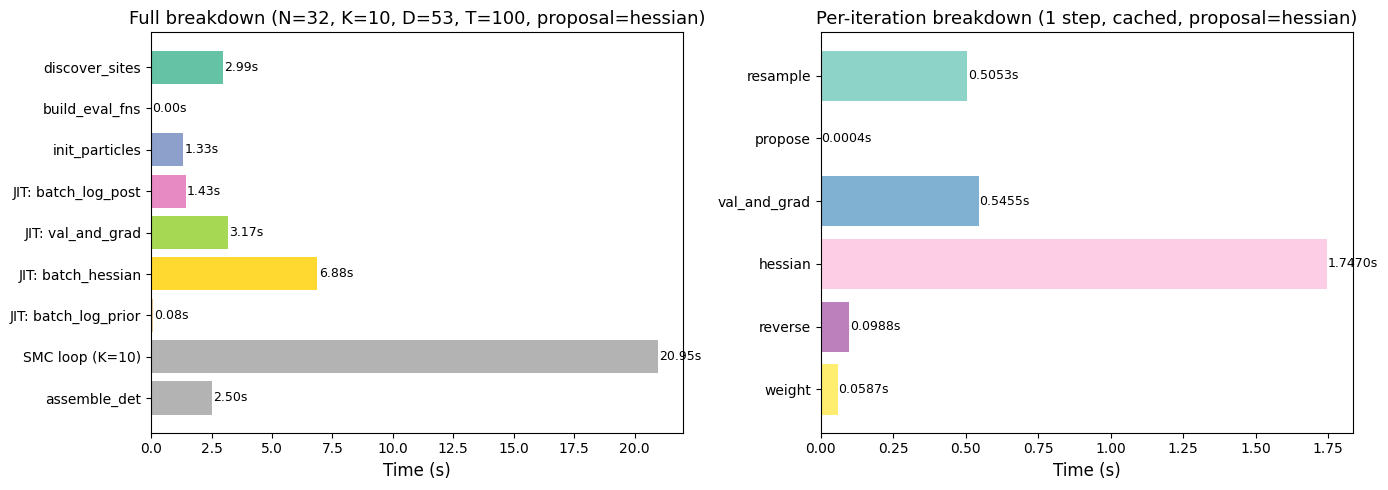

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: full breakdown
ax = axes[0]
labels = list(groups.keys())
vals = list(groups.values())
colors = plt.cm.Set2(np.linspace(0, 1, len(labels)))
bars = ax.barh(labels, vals, color=colors)
ax.set_xlabel("Time (s)", fontsize=12)
ax.set_title(f"Full breakdown (N={N}, K={K}, D={D}, T={T}, proposal={PROPOSAL})", fontsize=13)
for bar, v in zip(bars, vals):
    ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
            f"{v:.2f}s", va="center", fontsize=9)
ax.invert_yaxis()

# Right: per-iteration breakdown
ax2 = axes[1]
iter_labels = ["resample", "propose", "val_and_grad", "hessian", "reverse", "weight"]
iter_vals = [
    timings.get("  resample", 0),
    timings.get("  propose (vmapped)", 0),
    timings.get("  batch_val_and_grad (new particles)", 0),
    timings.get("  batch_hessian (new particles)", 0),
    timings.get("  reverse momentum (vmapped)", 0),
    timings.get("  weight update (vmapped)", 0),
]
colors2 = plt.cm.Set3(np.linspace(0, 1, len(iter_labels)))
bars2 = ax2.barh(iter_labels, iter_vals, color=colors2)
ax2.set_xlabel("Time (s)", fontsize=12)
ax2.set_title(f"Per-iteration breakdown (1 step, cached, proposal={PROPOSAL})", fontsize=13)
for bar, v in zip(bars2, iter_vals):
    ax2.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
            f"{v:.4f}s", va="center", fontsize=9)
ax2.invert_yaxis()

fig.tight_layout()